# A notebook with the FRB/US model
This notebook is based on the the FRB/US model packages located here (https://www.federalreserve.gov/econres/us-models-package.htm). The packages provides an Eviews (https://www.eviews.com/) implementation. The Eviews modelspecification has been transformed to ModelFlow BusinessLogic specification. 

In this notebook you can make your own experiments by updating variables. 

FRB/US comes in two flawors: **VAR** in which expectaions are generated by backward looking equations, and **MCE** in which expectation are based on leaded values. 
This notebook implement the **VAR** flavour. 

The tool used is highly experimental and the results are purely for illustration. 

You can run each cell by pressing the run tool or shift+enter
To run all cells use select cell/run all in the menu bar. 

# Import Python libraries

In [1]:
%matplotlib inline

import pandas as pd
from numba import jit


 
from modelclass import model  
import modelmf


# Prepare some stuff

In [2]:
turbo = 0  # Determines if the the model is compiled or not 

# define af function which is in Eviews but not in Python
@jit("f8(b1,f8,f8)")
def recode(condition,yes,no):
    '''Function which recratetes the functionality of @recode from eviews ''' 
    return yes if condition else no

# Load the model and the data 
The model and the data has been prepared in a preprocessor step. 

In [3]:
basedf  = pd.read_pickle('frbus/data/baseline.pc')

In [4]:
ffrbus  = open('frbus/model/ffrbusvar.txt','rt').read() 
# print(ffrbus)

# Create a model class instance

In [5]:
mfrbus = model(ffrbus,funks=[recode],modelname='FRB/US')

In [6]:
res = mfrbus(basedf,'2020q1','2025q4',max_iterations= 500,relconv=0.000000001,
             conv='XGDPN',ljit=turbo,silent=1,solver='sim')

# Run alternative 

In [33]:
# Make a new DataFrame
altdf = basedf.copy()

# Update variables in the dataframe
altdf=altdf.mfcalc('''\
rffintay_aerr = rffintay_aerr - 0.01
dmpex    = 0 
dmprr    = 0
dmptay   = 0
dmptlr   = 0 
dmpintay = 1
dmpalt   = 0
dmpgen   = 0

RFFMIN = 0.0
DMPTRSH = 0
'''.upper(),silent=1)

#Run the model 
with model.timer('Solve Frbus'):
    res2 = mfrbus(altdf,ldumpvar = 0,solver='newton',newton_absconv=0.0001)


Solve Frbus took       :         0.0787882805 Seconds


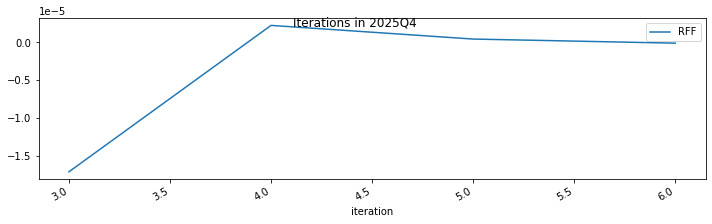

In [26]:
mfrbus.show_iterations('Rff',last=-5,change=1);

In [ ]:
trans = {'XGDPN':'GDP real terms (XGDPN)','RFF':'Federal Funds Rate (RFF)','GFSRPN':'Federal Budget surplus',
        'RFFMIN':'Minimum Fed Funds'}


# Show the results 

In [ ]:
_ = mfrbus['XGDPN RFF'].dif.rename(trans).plot(colrow=1,sharey=0)

# Some interfaces 
. (dot) makes it easy to look at single variable. 

\[ \] (Slice) alows inspection of many variables selected with wildcars

# How is the interest rate determined

In [ ]:
mfrbus.RFF.draw(up=1,down=1,HR=0,svg=1)

In [ ]:
with mfrbus.set_smpl('2020q1','2020q4'):
    mfrbus.rff.show

In [ ]:
with mfrbus.set_smpl('2020q1','2020q4'):
    mfrbus.rffintay.dekomp();

In [ ]:
with mfrbus.set_smpl('2020q1','2020q4'):
     mfrbus.rfftay.explain(up=1,svg=1,pdf=0);

In [ ]:
mfrbus['rffta* rffrule*']

In [ ]:
_ = mfrbus['rffta* rffrule*'].dif.plot(colrow=1,sharey=0)

In [ ]:
mfrbus.drawendo(lag=0,title='FRB/US endogeneous interpendencies',svg=1)
# you will find the output files in different format in the /graph folder

In [ ]:
fig   = mfrbus.plotadjacency(size=(40,40))
#fig.savefig('graph/FRB-US causality structure.pdf')